In [ ]:
%pip install pytorch-metric-learning torch torchvision opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
import glob
import random
from torchvision import transforms, models
import matplotlib.pyplot as plt

# Setup device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Using MPS for computation.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU for computation.")
else:
    device = torch.device("cpu")
    print("Using CPU for computation.")


MPS is available. Using MPS for computation.


In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        backbone = models.resnet18(weights='IMAGENET1K_V1')
        backbone.fc = nn.Flatten()
        self.backbone = backbone

    def forward_one(self, x):
        return self.backbone(x)

    def forward(self, x1, x2):
        output1 = self.forward_one(x1)
        output2 = self.forward_one(x2)
        return output1, output2


In [3]:
class SachetPairDataset(Dataset):
    def __init__(self, positive_samples, negative_samples, transform=None):
        self.positive_samples = positive_samples
        self.negative_samples = negative_samples
        self.transform = transform

    def __len__(self):
        return len(self.positive_samples) + len(self.negative_samples)

    def __getitem__(self, idx):
        if idx < len(self.positive_samples):
            img1_path, img2_path = self.positive_samples[idx]
            label = 1.0
        else:
            img1_path, img2_path = self.negative_samples[idx - len(self.positive_samples)]
            label = 0.0

        img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor([label], dtype=torch.float32)


In [4]:
sachet_dir = "../../data/images/clear/sample/"
background_dir = "../../data/images/clear/query/"

positive_samples = []
negative_samples = []

sachet_images = glob.glob(os.path.join(sachet_dir, "*.png"))
background_images = glob.glob(os.path.join(background_dir, "*.jpg"))

for i, img_path in enumerate(sachet_images):
    if i + 1 < len(sachet_images):
        positive_samples.append((img_path, sachet_images[i + 1]))
    else:
        positive_samples.append((img_path, sachet_images[0]))

for img_path in sachet_images:
    for bg_path in background_images[:3]:
        negative_samples.append((img_path, bg_path))

print(f"Created {len(positive_samples)} positive and {len(negative_samples)} negative samples")


Created 3 positive and 9 negative samples


In [5]:
image_size = 224

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SachetPairDataset(positive_samples, negative_samples, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

print(f"Training data: {len(train_dataset)} samples")
print(f"Validation data: {len(val_dataset)} samples")


Training data: 9 samples
Validation data: 3 samples


In [6]:
def contrastive_loss(distance, label, margin=1.0):
    loss = 0.5 * (label) * torch.pow(distance, 2) + \
           0.5 * (1 - label) * torch.pow(torch.clamp(margin - distance, min=0.0), 2)
    return torch.mean(loss)


In [7]:
def train_siamese_network(model, train_loader, val_loader, epochs=500, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for anchor, second, label in train_loader:
            anchor, second, label = anchor.to(device), second.to(device), label.to(device).view(-1)

            optimizer.zero_grad()
            embedding1, embedding2 = model(anchor, second)
            distance = F.pairwise_distance(embedding1, embedding2)
            loss = contrastive_loss(distance, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

    return model

model = SiameseNetwork().to(device)
trained_model = train_siamese_network(model, train_loader, val_loader, epochs=500)
torch.save(trained_model.state_dict(), "sachet_detection_model.pth")


Epoch [1/500], Loss: 27.0826
Epoch [2/500], Loss: 22.9215
Epoch [3/500], Loss: 29.1089
Epoch [4/500], Loss: 7.0352
Epoch [5/500], Loss: 1.3066
Epoch [6/500], Loss: 2.8217
Epoch [7/500], Loss: 1.2094
Epoch [8/500], Loss: 1.0774
Epoch [9/500], Loss: 0.9025
Epoch [10/500], Loss: 0.2018
Epoch [11/500], Loss: 0.5393
Epoch [12/500], Loss: 0.3422
Epoch [13/500], Loss: 0.5384
Epoch [14/500], Loss: 0.4550
Epoch [15/500], Loss: 0.1130
Epoch [16/500], Loss: 0.1864
Epoch [17/500], Loss: 0.1032
Epoch [18/500], Loss: 0.0943
Epoch [19/500], Loss: 0.1515
Epoch [20/500], Loss: 0.5527
Epoch [21/500], Loss: 0.2502
Epoch [22/500], Loss: 0.0566
Epoch [23/500], Loss: 0.9910
Epoch [24/500], Loss: 0.1680
Epoch [25/500], Loss: 0.2753
Epoch [26/500], Loss: 0.1224
Epoch [27/500], Loss: 0.4757
Epoch [28/500], Loss: 0.2855
Epoch [29/500], Loss: 0.1303
Epoch [30/500], Loss: 0.1220
Epoch [31/500], Loss: 0.0373
Epoch [32/500], Loss: 0.0207
Epoch [33/500], Loss: 0.0357
Epoch [34/500], Loss: 0.0470
Epoch [35/500], Loss

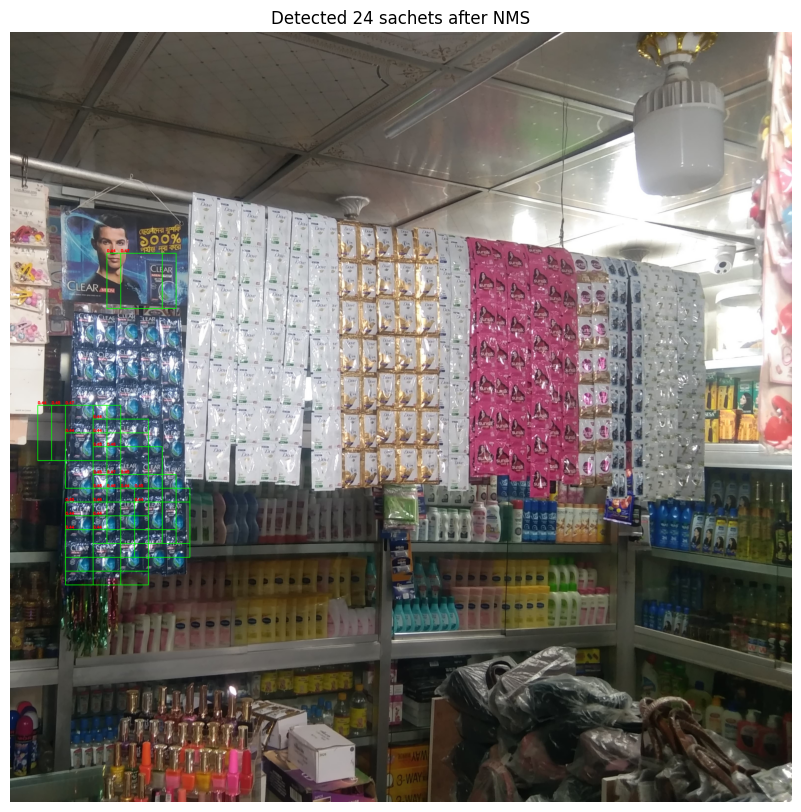

In [ ]:
def non_maximum_suppression(detections, iou_threshold=0.5):
    """
    Perform Non-Maximum Suppression (NMS) on detections.
    """
    if len(detections) == 0:
        return []

    # Convert detections to numpy array for easier manipulation
    boxes = np.array([[x, y, x + 224, y + 224, 1 / (1 + dist)] for (x, y, dist) in detections])
    scores = boxes[:, 4]

    # Sort boxes by scores (descending order)
    indices = scores.argsort()[::-1]
    selected_indices = []

    while len(indices) > 0:
        current = indices[0]
        selected_indices.append(current)

        # Calculate IoU
        x1 = np.maximum(boxes[current, 0], boxes[indices[1:], 0])
        y1 = np.maximum(boxes[current, 1], boxes[indices[1:], 1])
        x2 = np.minimum(boxes[current, 2], boxes[indices[1:], 2])
        y2 = np.minimum(boxes[current, 3], boxes[indices[1:], 3])

        # Compute intersection
        intersection_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
        box_area = (boxes[indices[1:], 2] - boxes[indices[1:], 0]) * (boxes[indices[1:], 3] - boxes[indices[1:], 1])
        current_area = (boxes[current, 2] - boxes[current, 0]) * (boxes[current, 3] - boxes[current, 1])
        union_area = box_area + current_area - intersection_area

        iou = intersection_area / (union_area + 1e-6)

        # Retain boxes with IoU less than the threshold
        indices = indices[1:][iou < iou_threshold]

    return boxes[selected_indices]


def detect_with_trained_model(model_path, sample_image_path, test_image_path, threshold=0.5, step_size=56, iou_threshold=0.3):
    model = SiameseNetwork().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    sample_img = cv2.cvtColor(cv2.imread(sample_image_path), cv2.COLOR_BGR2RGB)
    sample_tensor = transform(sample_img).unsqueeze(0).to(device)

    test_img = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
    sample_embedding = model.forward_one(sample_tensor)

    height, width = test_img.shape[:2]
    window_size = 224
    detections = []

    # Sliding window detection
    for y in range(0, height - window_size + 1, step_size):
        for x in range(0, width - window_size + 1, step_size):
            window = test_img[y:y + window_size, x:x + window_size]
            window_tensor = transform(window).unsqueeze(0).to(device)

            with torch.no_grad():
                window_embedding = model.forward_one(window_tensor)
                distance = F.pairwise_distance(sample_embedding, window_embedding).item()

            if distance < threshold:
                detections.append((x, y, distance))

    # Apply NMS to reduce overlaps
    nms_detections = non_maximum_suppression(detections, iou_threshold=iou_threshold)

    # Draw results
    result_img = test_img.copy()
    for (x1, y1, x2, y2, score) in nms_detections:
        cv2.rectangle(result_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(result_img, f"{score:.2f}", (int(x1), int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(12, 10))
    plt.imshow(result_img)
    plt.title(f"Detected {len(nms_detections)} sachets after NMS")
    plt.axis("off")
    plt.savefig('./results/a.png')
    plt.show()

    return nms_detections

# Run detection with NMS
nms_detections = detect_with_trained_model(
    "sachet_detection_model.pth",
    "../../data/images/clear/sample/clear1c.png",
    "../../data/images/clear/query/z.jpg",
    threshold=1.19,
    step_size=56,
    iou_threshold=0.25  # lower value = more suppression
)